<a href="https://colab.research.google.com/github/pandian-raja/EVA4_Session10/blob/master/GradCam_Trail.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Module import

In [3]:
!wget https://raw.githubusercontent.com/1Konny/gradcam_plus_plus-pytorch/master/gradcam.py

--2020-03-31 08:18:48--  https://raw.githubusercontent.com/1Konny/gradcam_plus_plus-pytorch/master/gradcam.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7628 (7.4K) [text/plain]
Saving to: ‘gradcam.py.1’

gradcam.py.1        100%[===================>]   7.45K  --.-KB/s    in 0s      

2020-03-31 08:18:49 (57.8 MB/s) - ‘gradcam.py.1’ saved [7628/7628]



In [4]:
!wget https://raw.githubusercontent.com/1Konny/gradcam_plus_plus-pytorch/master/utils.py

--2020-03-31 08:18:51--  https://raw.githubusercontent.com/1Konny/gradcam_plus_plus-pytorch/master/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7831 (7.6K) [text/plain]
Saving to: ‘utils.py.1’

utils.py.1          100%[===================>]   7.65K  --.-KB/s    in 0s      

2020-03-31 08:18:52 (51.7 MB/s) - ‘utils.py.1’ saved [7831/7831]



In [0]:
import os
import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision.models as models
from torchvision.utils import make_grid, save_image

# from utils import visualize_cam, Normalize


In [0]:
del GradCAM

### Load image

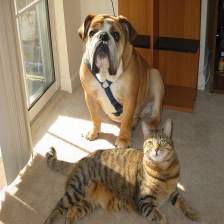

In [4]:
img_dir = 'images'
# img_name = 'collies.JPG'
# img_name = 'multiple_dogs.jpg'
# img_name = 'snake.JPEG'
img_path = 'catdog.png'
# img_path = os.path.join(img_dir, img_name)

pil_img = PIL.Image.open(img_path)
pil_img

### preprocess image

In [10]:
!pip install albumentations
!pip install torchsummary
from torchsummary import summary
import numpy as np


In [11]:
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session8/master/resnet.py
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session9/master/GetData.py

--2020-03-31 08:19:25--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session8/master/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4005 (3.9K) [text/plain]
Saving to: ‘resnet.py.1’

resnet.py.1         100%[===================>]   3.91K  --.-KB/s    in 0s      

2020-03-31 08:19:25 (56.9 MB/s) - ‘resnet.py.1’ saved [4005/4005]

--2020-03-31 08:19:26--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session9/master/GetData.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3234 (3.2K) [text/plain]
Saving to: ‘GetData

In [0]:
import resnet as rs
# import train_and_validate as tv
import GetData as gd

In [13]:
trainloader, testloader, classes, device = gd.GetData.importDataset()

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


In [0]:
model = rs.ResNet18().to(device);


In [15]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

### Load torchvision models and make model dictionaries

In [0]:
import torch
import torch.nn.functional as F

from utils import find_alexnet_layer, find_vgg_layer, find_resnet_layer, find_densenet_layer, find_squeezenet_layer


class GradCAM(object):
    """Calculate GradCAM salinecy map.

    A simple example:

        # initialize a model, model_dict and gradcam
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcam = GradCAM(model_dict)

        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)

        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcam(normed_img, class_idx=10)

        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)


    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        model_type = model_dict['type']
        layer_name = model_dict['layer_name']
        self.model_arch = model_dict['arch']

        self.gradients = dict()
        self.activations = dict()
        def backward_hook(module, grad_input, grad_output):
            self.gradients['value'] = grad_output[0]
            return None
        def forward_hook(module, input, output):
            self.activations['value'] = output
            return None

        if 'vgg' in model_type.lower():
            target_layer = find_vgg_layer(self.model_arch, layer_name)
        elif 'resnet' in model_type.lower():
            target_layer = find_resnet_layer(self.model_arch, layer_name)
        elif 'densenet' in model_type.lower():
            target_layer = find_densenet_layer(self.model_arch, layer_name)
        elif 'alexnet' in model_type.lower():
            target_layer = find_alexnet_layer(self.model_arch, layer_name)
        elif 'squeezenet' in model_type.lower():
            target_layer = find_squeezenet_layer(self.model_arch, layer_name)

        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)

        if verbose:
            try:
                input_size = model_dict['input_size']
            except KeyError:
                print("please specify size of input image in model_dict. e.g. {'input_size':(224, 224)}")
                pass
            else:
                device = 'cuda' if next(self.model_arch.parameters()).is_cuda else 'cpu'
                self.model_arch(torch.zeros(1, 3, *(input_size), device=device))
                print('saliency_map size :', self.activations['value'].shape[2:])


    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze()

        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value']
        activations = self.activations['value']
        b, k, u, v = gradients.size()

        alpha = gradients.view(b, k, -1).mean(2)
        #alpha = F.relu(gradients.view(b, k, -1)).mean(2)
        weights = alpha.view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map - saliency_map_min).div(saliency_map_max - saliency_map_min).data

        return saliency_map, logit

    def __call__(self, input, class_idx=None, retain_graph=False):
        return self.forward(input, class_idx, retain_graph)


class GradCAMpp(GradCAM):
    """Calculate GradCAM++ salinecy map.

    A simple example:

        # initialize a model, model_dict and gradcampp
        resnet = torchvision.models.resnet101(pretrained=True)
        resnet.eval()
        model_dict = dict(model_type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
        gradcampp = GradCAMpp(model_dict)

        # get an image and normalize with mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
        img = load_img()
        normed_img = normalizer(img)

        # get a GradCAM saliency map on the class index 10.
        mask, logit = gradcampp(normed_img, class_idx=10)

        # make heatmap from mask and synthesize saliency map using heatmap and img
        heatmap, cam_result = visualize_cam(mask, img)


    Args:
        model_dict (dict): a dictionary that contains 'model_type', 'arch', layer_name', 'input_size'(optional) as keys.
        verbose (bool): whether to print output size of the saliency map givien 'layer_name' and 'input_size' in model_dict.
    """
    def __init__(self, model_dict, verbose=False):
        super(GradCAMpp, self).__init__(model_dict, verbose)

    def forward(self, input, class_idx=None, retain_graph=False):
        """
        Args:
            input: input image with shape of (1, 3, H, W)
            class_idx (int): class index for calculating GradCAM.
                    If not specified, the class index that makes the highest model prediction score will be used.
        Return:
            mask: saliency map of the same spatial dimension with input
            logit: model output
        """
        b, c, h, w = input.size()

        logit = self.model_arch(input)
        if class_idx is None:
            score = logit[:, logit.max(1)[-1]].squeeze()
        else:
            score = logit[:, class_idx].squeeze() 
            
        self.model_arch.zero_grad()
        score.backward(retain_graph=retain_graph)
        gradients = self.gradients['value'] # dS/dA
        activations = self.activations['value'] # A
        b, k, u, v = gradients.size()

        alpha_num = gradients.pow(2)
        alpha_denom = gradients.pow(2).mul(2) + \
                activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
        alpha_denom = torch.where(alpha_denom != 0.0, alpha_denom, torch.ones_like(alpha_denom))

        alpha = alpha_num.div(alpha_denom+1e-7)
        positive_gradients = F.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
        weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

        saliency_map = (weights*activations).sum(1, keepdim=True)
        saliency_map = F.relu(saliency_map)
        saliency_map = F.upsample(saliency_map, size=(32, 32), mode='bilinear', align_corners=False)
        saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
        saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data

        return saliency_map, logit


In [38]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
torch_img = torch.from_numpy(np.asarray(im)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
torch_img = F.upsample(torch_img, size=(32, 32), mode='bilinear', align_corners=False)
normed_torch_img = normalizer(torch_img)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [26]:
cam_dict = dict()
resnet_model_dict = dict(type='resnet', arch=model, layer_name='layer4', input_size=(32, 32))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)


saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])


In [0]:
del GradCAMpp

In [0]:
dataiter = iter(testloader)
images, labels = dataiter.next()

In [0]:
from torchvision import transforms
import torch
import torchvision
t = torchvision.utils.make_grid(images[0].cpu())

im = transforms.ToPILImage()(t)


In [39]:
mask, _ = resnet_gradcam(normed_torch_img)
heatmap, result = visualize_cam2(mask, torch_img)


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [0]:
import numpy as np 
i1 = transforms.ToPILImage()(result)
i2 = transforms.ToPILImage()(heatmap)


In [72]:
i1[0]

array([[0.11960784, 0.12352941, 0.14705883, ..., 0.0372549 , 0.49607843,
        0.45686275],
       [0.09607843, 0.09215686, 0.12352941, ..., 0.03333334, 0.49215686,
        0.46862745],
       [0.09215686, 0.09215686, 0.11960784, ..., 0.04509804, 0.00980392,
        0.47254902],
       ...,
       [0.26862746, 0.16666667, 0.12352941, ..., 0.1509804 , 0.05294118,
        0.15882353],
       [0.24117647, 0.19411765, 0.1392157 , ..., 0.10392157, 0.11568628,
        0.08039216],
       [0.21372549, 0.22156863, 0.17843138, ..., 0.09607843, 0.13529412,
        0.08431373]], dtype=float32)

In [0]:
dd = imgfin

In [76]:

plt.imshow(np.rollaxis(dd[0], 0, 3))
#  a = np.expand_dims(a, axis=0)  # or axis=1
# plt.imshow(a)
# plt.show()

AxisError: ignored

In [77]:

imgfin = cv2.addWeighted(i1,0.9,i2,0.1,0)


TypeError: ignored

In [74]:
# dd = dd.squeeze()
plt.imshow(cv2.addWeighted(transforms.ToPILImage()(result),0.9,transforms.ToPILImage()(heatmap),0.1,0))


TypeError: ignored

In [0]:
from PIL import Image
from cv2 import *


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


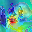

In [62]:
transforms.ToPILImage()(getGradCamImg(im))

In [0]:
def getGradCamImg(im):
  normalizer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
  torch_img = torch.from_numpy(np.asarray(im)).permute(2, 0, 1).unsqueeze(0).float().div(255).cuda()
  torch_img = F.upsample(torch_img, size=(32, 32), mode='bilinear', align_corners=False)
  normed_torch_img = normalizer(torch_img)
  mask, _ = resnet_gradcam(normed_torch_img)
  heatmap, result = visualize_cam2(mask, torch_img)
  return result

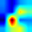

In [49]:
transforms.ToPILImage()(heatmap)

In [0]:
def wrong_plot2(true,ima,pred,encoder,inv_normalize,n_figures ):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/5)
    fig,axes = plt.subplots(figsize=(15, 15), nrows = n_row, ncols=5)
    print(axes)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
        image,correct,wrong = ima[a],true[a],pred[a]
        # image = image.cuda()
        # image = image.cpu()
        # image = image.numpy()
        # # correct = int(correct)
        # c = encoder[correct]
        # wrong = int(wrong)
        # w = encoder[wrong]
        # f = 'A:'+str(c.item()) + ',' +'P:'+str(w.item())
        # f = 'A:'+str(correct[0]) + ',' +'P:'+str(wrong[0])
        f = 'A:'+classes[correct[0]] + ',' +'P:'+classes[wrong[0]]
        # image = image.numpy().transpose(1,2,0)
        # image = image.squeeze()
        # im = ax.imshow(cv2.cvtColor(torchvision.utils.make_grid(image[0].cpu(), nrow=5).permute(1, 2, 0), cv2.COLOR_BGR2RGB))
        ax.imshow(transforms.ToPILImage()(getGradCamImg(torchvision.utils.make_grid(image.cpu(), nrow=5).permute(1, 2, 0))), cmap='brg', interpolation='none')
        ax.set_title(f)
        ax.axis('off')
    plt.show()

In [0]:
def validate(testloader, device, model):
        pred_wrong = []
        true_wrong = []
        image = []
        dataiter = iter(testloader)
        images, labels = dataiter.next()
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        correct = 0
        total = 0
        with torch.no_grad():
            for data in testloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                # print(predicted)
                # print(labels)
                preds = predicted.cpu().numpy()
                target = labels.cpu().numpy()
                preds = np.reshape(preds,(len(preds),1))
                target = np.reshape(target,(len(preds),1))
                for i in range(len(preds)):
                    # pred.append(preds[i])
                    # true.append(target[i])
                    if(preds[i]!=target[i]):
                        pred_wrong.append(preds[i])
                        true_wrong.append(target[i])
                        image.append(images[i])
                # if(predicted != labels):
                #     pred_wrong.append(predicted)
                #     true_wrong.append(labels)
                #     image.append(data[i])
        print('Accuracy of the network on the 10000 test images: %2d %%' % ((100 * correct) / total))
        return image,true_wrong,pred_wrong


Classes in order Actual and Predicted
[[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4d7036d5c0>


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


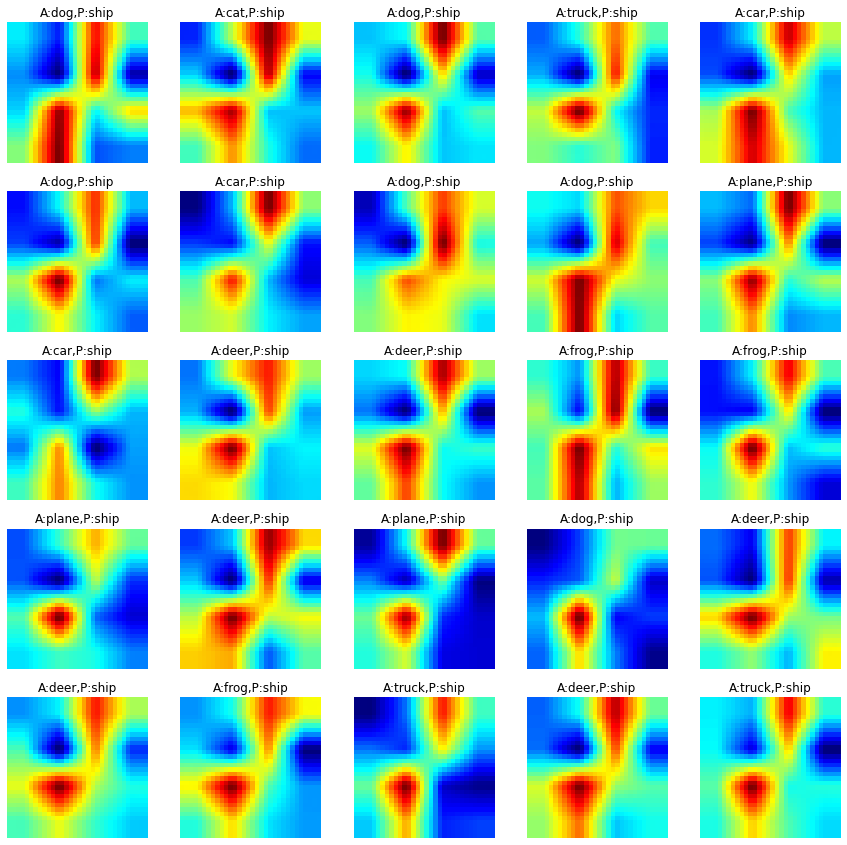

In [33]:
wrong_plot2(true_wrong,img,pred_wrong,testloader.dataset.targets,None,25)

In [27]:
img,true_wrong,pred_wrong = validate(testloader,device,model)

Accuracy of the network on the 10000 test images: 10 %


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
from torchvision import transforms
import torch
import torchvision

In [0]:
images = []
for gradcam, gradcam_pp in cam_dict.values():
    mask, _ = gradcam(normed_torch_img)
    heatmap, result = visualize_cam2(mask, torch_img)

    mask_pp, _ = gradcam_pp(normed_torch_img)
    heatmap_pp, result_pp = visualize_cam2(mask_pp, torch_img)
    
    images.append(torch.stack([torch_img.squeeze().cpu(), heatmap, heatmap_pp, result, result_pp], 0))
    
images = make_grid(torch.cat(images, 0), nrow=5)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


In [0]:
import cv2
import numpy as np
import torch

def visualize_cam2(mask, img):
    """Make heatmap from mask and synthesize GradCAM result image using heatmap and img.
    Args:
        mask (torch.tensor): mask shape of (1, 1, H, W) and each element has value in range [0, 1]
        img (torch.tensor): img shape of (1, 3, H, W) and each pixel value is in range [0, 1]
        
    Return:
        heatmap (torch.tensor): heatmap img shape of (3, H, W)
        result (torch.tensor): synthesized GradCAM result of same shape with heatmap.
    """
    heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().cpu()), cv2.COLORMAP_JET)
    heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
    b, g, r = heatmap.split(1)
    heatmap = torch.cat([r, g, b])
    
    result = heatmap+img.cpu()

    result = result.div(result.max()).squeeze()
    
    return heatmap, result

In [0]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval(), alexnet.cuda();

vgg = models.vgg16(pretrained=True)
vgg.eval(), vgg.cuda();

resnet = models.resnet101(pretrained=True)
resnet.eval(), resnet.cuda();

densenet = models.densenet161(pretrained=True)
densenet.eval(), densenet.cuda();

squeezenet = models.squeezenet1_1(pretrained=True)
squeezenet.eval(), squeezenet.cuda();


cam_dict = dict()

alexnet_model_dict = dict(type='alexnet', arch=alexnet, layer_name='features_11', input_size=(224, 224))
alexnet_gradcam = GradCAM(alexnet_model_dict, True)
alexnet_gradcampp = GradCAMpp(alexnet_model_dict, True)
cam_dict['alexnet'] = [alexnet_gradcam, alexnet_gradcampp]

vgg_model_dict = dict(type='vgg', arch=vgg, layer_name='features_29', input_size=(224, 224))
vgg_gradcam = GradCAM(vgg_model_dict, True)
vgg_gradcampp = GradCAMpp(vgg_model_dict, True)
cam_dict['vgg'] = [vgg_gradcam, vgg_gradcampp]

resnet_model_dict = dict(type='resnet', arch=resnet, layer_name='layer4', input_size=(224, 224))
resnet_gradcam = GradCAM(resnet_model_dict, True)
resnet_gradcampp = GradCAMpp(resnet_model_dict, True)
cam_dict['resnet'] = [resnet_gradcam, resnet_gradcampp]

densenet_model_dict = dict(type='densenet', arch=densenet, layer_name='features_norm5', input_size=(224, 224))
densenet_gradcam = GradCAM(densenet_model_dict, True)
densenet_gradcampp = GradCAMpp(densenet_model_dict, True)
cam_dict['densenet'] = [densenet_gradcam, densenet_gradcampp]

squeezenet_model_dict = dict(type='squeezenet', arch=squeezenet, layer_name='features_12_expand3x3_activation', input_size=(224, 224))
squeezenet_gradcam = GradCAM(squeezenet_model_dict, True)
squeezenet_gradcampp = GradCAMpp(squeezenet_model_dict, True)
cam_dict['squeezenet'] = [squeezenet_gradcam, squeezenet_gradcampp]

In [0]:
heatmap, result = visualize_cam2(mask, torch_img)

tensor([[[[0.0779, 0.0779, 0.0779,  ..., 0.0733, 0.0733, 0.0733],
          [0.0779, 0.0779, 0.0779,  ..., 0.0733, 0.0733, 0.0733],
          [0.0779, 0.0779, 0.0779,  ..., 0.0733, 0.0733, 0.0733],
          ...,
          [0.0446, 0.0446, 0.0446,  ..., 0.0554, 0.0554, 0.0554],
          [0.0446, 0.0446, 0.0446,  ..., 0.0554, 0.0554, 0.0554],
          [0.0446, 0.0446, 0.0446,  ..., 0.0554, 0.0554, 0.0554]]]],
       device='cuda:0')

In [0]:
heatmap = cv2.applyColorMap(np.uint8(255 * mask.squeeze().cuda().cpu()), cv2.COLORMAP_JET)
heatmap = torch.from_numpy(heatmap).permute(2, 0, 1).float().div(255)
b, g, r = heatmap.split(1)
heatmap = torch.cat([r, g, b])
result = heatmap+torch_img.cpu()
result = result.div(result.max()).squeeze()


### Feedforward image, calculate GradCAM/GradCAM++, and gather results

### Save and show results 

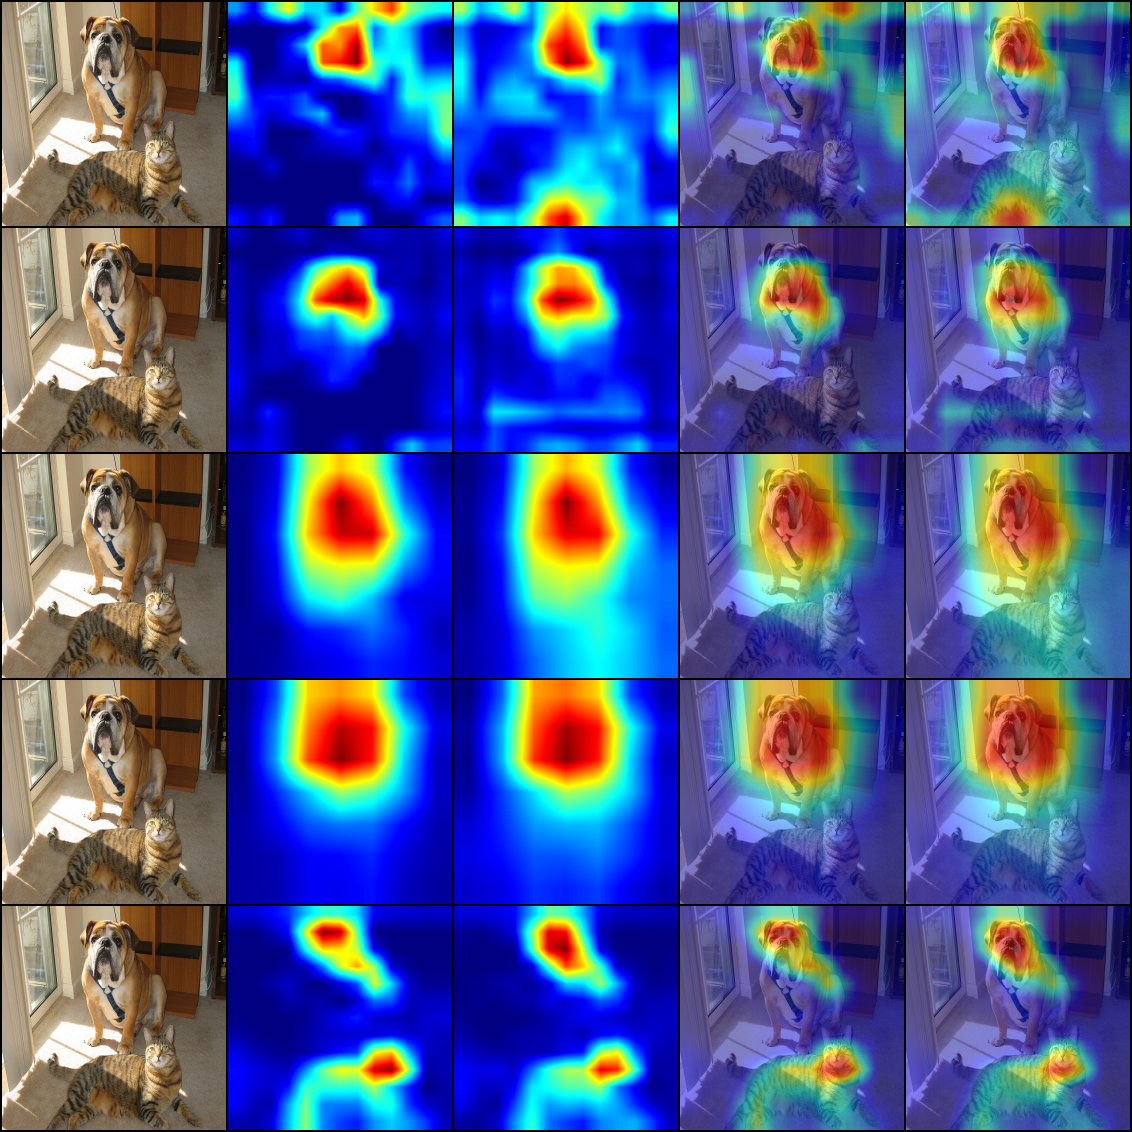

In [0]:
output_dir = 'outputs'
os.makedirs(output_dir, exist_ok=True)
# output_name = ""
# output_path = os.path.join(output_dir, output_name)

save_image(images, img_path)
PIL.Image.open(img_path)

In [0]:
!pip install albumentations
!pip install torchsummary
from torchsummary import summary
import numpy as np


     |████████████████████████████████| 634kB 9.3MB/s 
  Created wheel for imgaug: filename=imgaug-0.2.6-cp36-none-any.whl size=654020 sha256=1b7fb4c09167d34f8e2f03e513a732a15d62d51130210743cd4620491ecc9397
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


In [0]:
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session8/master/resnet.py

--2020-03-28 02:15:48--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session8/master/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4005 (3.9K) [text/plain]
Saving to: ‘resnet.py’

resnet.py           100%[===================>]   3.91K  --.-KB/s    in 0s      

2020-03-28 02:15:48 (132 MB/s) - ‘resnet.py’ saved [4005/4005]



In [0]:
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session7/master/train_and_validate.py

--2020-03-28 02:15:51--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session7/master/train_and_validate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2734 (2.7K) [text/plain]
Saving to: ‘train_and_validate.py’

train_and_validate. 100%[===================>]   2.67K  --.-KB/s    in 0s      

2020-03-28 02:15:51 (51.4 MB/s) - ‘train_and_validate.py’ saved [2734/2734]



In [0]:
!wget https://raw.githubusercontent.com/pandian-raja/EVA4_Session9/master/GetData.py

--2020-03-28 02:15:54--  https://raw.githubusercontent.com/pandian-raja/EVA4_Session9/master/GetData.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3234 (3.2K) [text/plain]
Saving to: ‘GetData.py’

GetData.py          100%[===================>]   3.16K  --.-KB/s    in 0s      

2020-03-28 02:15:55 (117 MB/s) - ‘GetData.py’ saved [3234/3234]



In [0]:
import resnet as rs
import train_and_validate as tv
import GetData as gd

In [0]:
trainloader, testloader, classes, device = gd.GetData.importDataset()


CUDA Available? True


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [0]:
model = rs.ResNet18().to(device);


In [0]:
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [0]:
model = tv.train_and_validate.train(trainloader,device,model,2)

[1,  2000] loss: 2.114
[1,  4000] loss: 1.859
[1,  6000] loss: 1.702
[1,  8000] loss: 1.566
[1, 10000] loss: 1.489
[1, 12000] loss: 1.389
[2,  2000] loss: 1.266
[2,  4000] loss: 1.228
[2,  6000] loss: 1.207
[2,  8000] loss: 1.148
[2, 10000] loss: 1.097
[2, 12000] loss: 1.092
Finished Training


In [0]:
tv.train_and_validate.validate(testloader,device,model)

Accuracy of the network on the 10000 test images: 61 %


In [0]:
class albumCompose:
    def __init__(self):
        self.albumentations_transform = Compose({
            Cutout(max_h_size=12,max_w_size=12,num_holes=1,p=0.5),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        })
    def __call__(self, img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        return torch.tensor(img, dtype=torch.float)

class albumCompose_test:
    def __init__(self):
        self.albumentations_transform = Compose({
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        })
    def __call__(self, img):
        img = np.array(img)
        img = self.albumentations_transform(image=img)['image']
        img = np.transpose(img, (2, 0, 1)).astype(np.float32)
        return torch.tensor(img, dtype=torch.float)


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from albumentations.pytorch import ToTensor
from albumentations import Compose, RandomCrop, Normalize, HorizontalFlip, Cutout, VerticalFlip
from albumentations.pytorch import ToTensor

In [0]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=albumCompose())
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=albumCompose_test())

Files already downloaded and verified
Files already downloaded and verified


In [0]:
resnet_model_dict = dict(type='resnet', arch=model, layer_name='layer4', input_size=(32, 32))

resnet_gradcam = GradCAM(resnet_model_dict,True)
resnet_gradcampp = GradCAMpp(resnet_model_dict,True)


saliency_map size : torch.Size([4, 4])
saliency_map size : torch.Size([4, 4])


In [0]:
# import random
# import random

# images = [x['image'] for x in random.sample(testset, 4)]


TypeError: ignored

In [0]:
def wrong_plot(true,ima,pred,encoder,inv_normalize,n_figures ):
    print('Classes in order Actual and Predicted')
    n_row = int(n_figures/5)
    fig,axes = plt.subplots(figsize=(10, 10), nrows = n_row, ncols=5)
    for ax in axes.flatten():
        a = random.randint(0,len(true)-1)
    
        image,correct,wrong = ima[a],true[a],pred[a]
        image = torch.from_numpy(image)
        correct = int(correct)
        c = encoder[correct]
        wrong = int(wrong)
        w = encoder[wrong]
        f = 'A:'+str(c.item()) + ',' +'P:'+str(w.item())
        f = 'A:'+str(correct) + ',' +'P:'+str(wrong)
        # image = image.numpy().transpose(1,2,0)
        image = image.squeeze()
        im = ax.imshow(image, cmap='gray', interpolation='none')
        ax.set_title(f)
        ax.axis('off')
    plt.show()

In [0]:
testset[0]

(tensor([[[ 0.2392,  0.2471,  0.2941,  ...,  0.0745, -0.0118, -0.0902],
          [ 0.1922,  0.1843,  0.2471,  ...,  0.0667, -0.0196, -0.0667],
          [ 0.1843,  0.1843,  0.2392,  ...,  0.0902,  0.0196, -0.0588],
          ...,
          [-0.4667, -0.6706, -0.7569,  ..., -0.7020, -0.8980, -0.6863],
          [-0.5216, -0.6157, -0.7255,  ..., -0.7961, -0.7725, -0.8431],
          [-0.5765, -0.5608, -0.6471,  ..., -0.8118, -0.7333, -0.8353]],
 
         [[-0.1216, -0.1294, -0.0902,  ..., -0.2549, -0.2863, -0.3333],
          [-0.1216, -0.1373, -0.1059,  ..., -0.2549, -0.2863, -0.3098],
          [-0.1373, -0.1451, -0.1294,  ..., -0.2314, -0.2549, -0.3020],
          ...,
          [-0.0275, -0.2157, -0.3098,  ..., -0.2392, -0.4980, -0.3333],
          [-0.0902, -0.2000, -0.3333,  ..., -0.3569, -0.3569, -0.4980],
          [-0.1608, -0.1765, -0.3020,  ..., -0.3961, -0.3412, -0.4745]],
 
         [[-0.6157, -0.6314, -0.6000,  ..., -0.7176, -0.7176, -0.7412],
          [-0.6000, -0.6863,

In [0]:
mask, _ = gradcam(images[0])
heatmap, result = visualize_cam(mask, images[0])

NameError: ignored

In [0]:
import gradcam 